# Choice of the optimizers

In [ ]:
# Read readme.md from github# Train the model
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Mounted at /gdrive
/gdrive/My Drive/Challenge_1


## Import Python packages

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"
# Train the model# Train the model
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

2.14.0


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
IMG_SIZE = 224

## Import dataset

In [ ]:
dataset = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab
images = dataset['data']
labels = dataset['labels']

In [ ]:
# Extract classes separately
healthy_labels = np.where(labels == "healthy")[0]
unhealthy_labels = np.where(labels == "unhealthy")[0]

healthy_images = images[healthy_labels]
unhealthy_images = images[unhealthy_labels]

### Split dataset

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)
y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.2, stratify=y
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.2,
    stratify=y_train_val,
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2900, 96, 96, 3), y_train shape: (2900,)
X_val shape: (725, 96, 96, 3), y_val shape: (725,)
X_test shape: (907, 96, 96, 3), y_test shape: (907,)


### preproces input - EfficientNet


In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.efficientnet_v2.preprocess_input (X_input)
    return X_input

X_train = proc_input(X_train)
X_val = proc_input(X_val)
# X_test = proc_input(X_test)  ## See last function


In [ ]:
def populate_dataset(originalDataset: np.ndarray, augmentMethodDict: dict, wantedSize:int) -> np.ndarray:
  # Calculate the sum of the values in the dictionary,
  total_prob = np.sum(list(augmentMethodDict.values()))

  # Check if the sum is not equal to 1 (with some tolerance for floating-point precision)
  if not np.isclose(total_prob, 1.0):
      # Normalize the values in the dictionary to make the sum equal to 1
      augmentMethodDict = {key: value / total_prob for key, value in augmentMethodDict.items()}

  print(augmentMethodDict)

  diff = wantedSize - len(originalDataset)

  for AugFunct, percentage in augmentMethodDict.items():
    number_of_images = int(percentage * diff)
    random_indices = np.random.choice(len(originalDataset), number_of_images, replace=False)
    random_elements = originalDataset[random_indices]
    augmented_images = AugFunct(random_elements)
    originalDataset = np.concatenate((originalDataset, augmented_images))

  if len(originalDataset) < wantedSize:
    diff = wantedSize - len(originalDataset)
    random_indices = np.random.choice(len(originalDataset), diff, replace=False)
    random_elements = originalDataset[random_indices]
    originalDataset = np.concatenate((originalDataset, random_elements))

  if len(originalDataset) > wantedSize:
    originalDataset = originalDataset[:wantedSize]

  return originalDataset

In [ ]:
flip = tf.keras.Sequential(
    [
        tfkl.RandomFlip("horizontal"),
    ]
)

translation = tf.keras.Sequential(
    [
        tfkl.RandomTranslation(0.2, 0.2),
    ]
)

rotation = tf.keras.Sequential(
    [
        tfkl.RandomRotation(0.2),
    ]
)


augmentMethodDict = {
    flip: 0.3,
    translation: 0.3,
    rotation: 0.4,
}


In [ ]:
X_train = X_train.numpy()
# Seperate the healthy and unhealthy images
healthy_images = X_train[np.where(y_train == 0)[0]]
unhealthy_images = X_train[np.where(y_train == 1)[0]]

#healthy_images = tf.convert_to_tensor(populate_dataset(healthy_images, augmentMethodDict, len(healthy_images)))
unhealthy_images = tf.convert_to_tensor(populate_dataset(unhealthy_images, augmentMethodDict, len(healthy_images)))
print(healthy_images.shape)
print(unhealthy_images.shape)
# Concatenate the healthy and unhealthy images
X_train = tf.concat([healthy_images, unhealthy_images], axis=0)

# Create the labels healthy and unhealthy
healthy_labels = tf.convert_to_tensor([0] * len(healthy_images))
unhealthy_labels = tf.convert_to_tensor([1] * len(unhealthy_images))
y_train = tf.concat([healthy_labels, unhealthy_labels], axis=0)

# Shuffle the data
# Shuffle the data wich is an np.array
X_train, y_train = tf.random.shuffle(X_train, seed=seed), tf.random.shuffle(y_train, seed=seed)

{<keras.src.engine.sequential.Sequential object at 0x79b93e5aaec0>: 0.3, <keras.src.engine.sequential.Sequential object at 0x79b93e5ab4f0>: 0.3, <keras.src.engine.sequential.Sequential object at 0x79b93e5abb20>: 0.4}
(1856, 224, 224, 3)
(1856, 224, 224, 3)


In [ ]:
X_train.shape

TensorShape([3712, 224, 224, 3])

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = 1
batch_size = 32
epochs = 30

# Print input shape, batch size, and number of epochs
print(
    f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}"
)

Input Shape: (224, 224, 3), Output Shape: 1, Batch Size: 32, Epochs: 30


### Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

calbacks = [reduce_lr, early_stopping]

In [ ]:
img_augmentation = tfk.Sequential(
    [
        tfk.layers.RandomRotation(factor=0.15),
        tfk.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfk.layers.RandomFlip(),
        tfk.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## Test optimizers for the frozen part


We build a dictionnary with optimizers to test them one by one

In [ ]:
optimizers = {"Adam": tfk.optimizers.Adam,"Nadam": tfk.optimizers.Nadam,"Adamax": tfk.optimizers.Adamax}
frozen_learning_rate = 1e-2
unfrozen_learning_rate = 1e-4

In [ ]:
from keras.api._v2.keras.applications import EfficientNetB0

def build_model(num_classes,optimizer):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.2, name="top1_dropout")(x)
    x = tfk.layers.Dense(
        20, activation="elu", kernel_initializer=tfk.initializers.HeUniform(seed=seed)
    )(x)
    x = tfk.layers.Dropout(0.3, name="to_dropout")(x)
    x = tfk.layers.Dense(
        10, activation="elu", kernel_initializer=tfk.initializers.HeUniform(seed=seed)
    )(x)
    x = tfk.layers.BatchNormalization()(x)
    outputs = tfk.layers.Dense(
        num_classes,
        activation="sigmoid",
        name="pred",
        kernel_initializer=tfk.initializers.GlorotUniform(seed=seed),
    )(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer(frozen_learning_rate), loss=loss, metrics=metrics)
    return model


We train frozen EffectiveNetB0 based models with differents optimizers to keep the best

In [ ]:
results_frozen = []
for optimizer in optimizers.keys():
    model = build_model(num_classes=1,optimizer=optimizers[optimizer])

    # Train the model
    epochs = 29  # @param {type: "slider", min:1, max:80}
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=calbacks,
        verbose=1,
    ).history

    results_frozen.append([optimizer,history])

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/29
116/116 [==============================] - 32s 116ms/step - loss: 0.5462 - accuracy: 0.7263 - val_loss: 0.5702 - val_accuracy: 0.6786 - lr: 0.0100
Epoch 2/29
116/116 [==============================] - 11s 96ms/step - loss: 0.4522 - accuracy: 0.7915 - val_loss: 0.4620 - val_accuracy: 0.7655 - lr: 0.0100
Epoch 3/29
116/116 [==============================] - 10s 85ms/step - loss: 0.4288 - accuracy: 0.8031 - val_loss: 0.4111 - val_accuracy: 0.8083 - lr: 0.0100
Epoch 4/29
116/116 [==============================] - 11s 99ms/step - loss: 0.4168 - accuracy: 0.8133 - val_loss: 0.4011 - val_accuracy: 0.7986 - lr: 0.0100
Epoch 5/29
116/116 [==============================] - 12s 101ms/step - loss: 0.4177 - accuracy: 0.8101 - val_loss: 0.3981 - val_accuracy: 0.8097 - lr: 0.0100
Epoch 6/29
116/116 [==============================] - 11s 96ms/step - loss: 0.3933 - accuracy: 0.8233 - val_loss: 0.3764 - val_accuracy: 0.8179 - lr

### Results of the frozen part

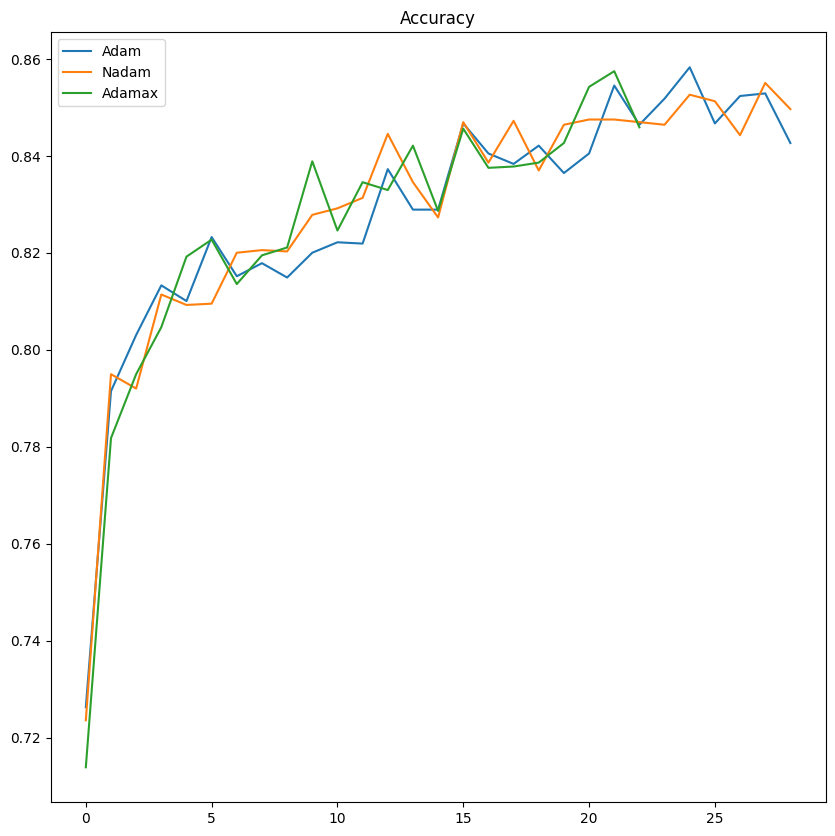

In [ ]:
# Plot the accuracy for the different optimizers on a same graph
plt.figure(figsize=(10, 10))
for result in results_frozen:
    plt.plot(result[1]["accuracy"], label=result[0])
plt.title("Accuracy")
plt.legend()
plt.show()


In [ ]:
#keep the optimizer with the best accuracy
best_optimizer = None
best_accuracy = 0.0

for result in results_frozen:
    if result[1]["accuracy"][-1] > best_accuracy:
        best_accuracy = result[1]["accuracy"][-1]
        best_optimizer = result[0]

best_frozen_optimizer = optimizers[best_optimizer]

The results show us that the best model for the frozen part is **Nadam**. We will build a model using it for the first phase and then try different optimizers for the unfrozen prat.

## Test optimizers for the unfrozen part

In [ ]:
def unfreeze_model(model,optimizer):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=optimizer(unfrozen_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"]
    )

Build a new frozen model with the best optimizer

In [ ]:
model = build_model(num_classes=1,optimizer=best_frozen_optimizer)
model.summary()

epochs = 40  # @param {type: "slider", min:1, max:80}
hist = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 224, 224, 3)          0         ['input_4[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['img_augmentation[3][0]']    
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]

Then we try differents optimizer for the unfrozen part of the training and keep the best

In [ ]:
# unfreeze the model
unfreeze_model(model,optimizer=best_frozen_optimizer)
model.save("unfronzen_model.h5")
results_unfrozen = []
# Try each optimizer with the unfrozen model
for optimizer in optimizers.keys():
    # Load the model
    model = tf.keras.models.load_model("unfronzen_model.h5")
    # Train the model
    epochs = 30  # @param {type: "slider", min:1, max:80}
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=calbacks,
        verbose=1,
    ).history
    results_unfrozen.append([optimizer,history])

Epoch 1/30
116/116 [==============================] - 21s 110ms/step - loss: 0.0000e+00 - accuracy: 0.8572 - val_loss: 0.0000e+00 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 2/30
116/116 [==============================] - 11s 98ms/step - loss: 0.0000e+00 - accuracy: 0.8728 - val_loss: 0.0000e+00 - val_accuracy: 0.8372 - lr: 1.0000e-04
Epoch 3/30
116/116 [==============================] - 12s 106ms/step - loss: 0.0000e+00 - accuracy: 0.8559 - val_loss: 0.0000e+00 - val_accuracy: 0.8345 - lr: 1.0000e-04
Epoch 4/30
116/116 [==============================] - 12s 104ms/step - loss: 0.0000e+00 - accuracy: 0.8621 - val_loss: 0.0000e+00 - val_accuracy: 0.8414 - lr: 1.0000e-04
Epoch 5/30
116/116 [==============================] - 12s 104ms/step - loss: 0.0000e+00 - accuracy: 0.8755 - val_loss: 0.0000e+00 - val_accuracy: 0.8455 - lr: 1.0000e-04
Epoch 6/30
116/116 [==============================] - 12s 107ms/step - loss: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.0000e+00 - val_accuracy: 0.849

### Results for the unfrozen part

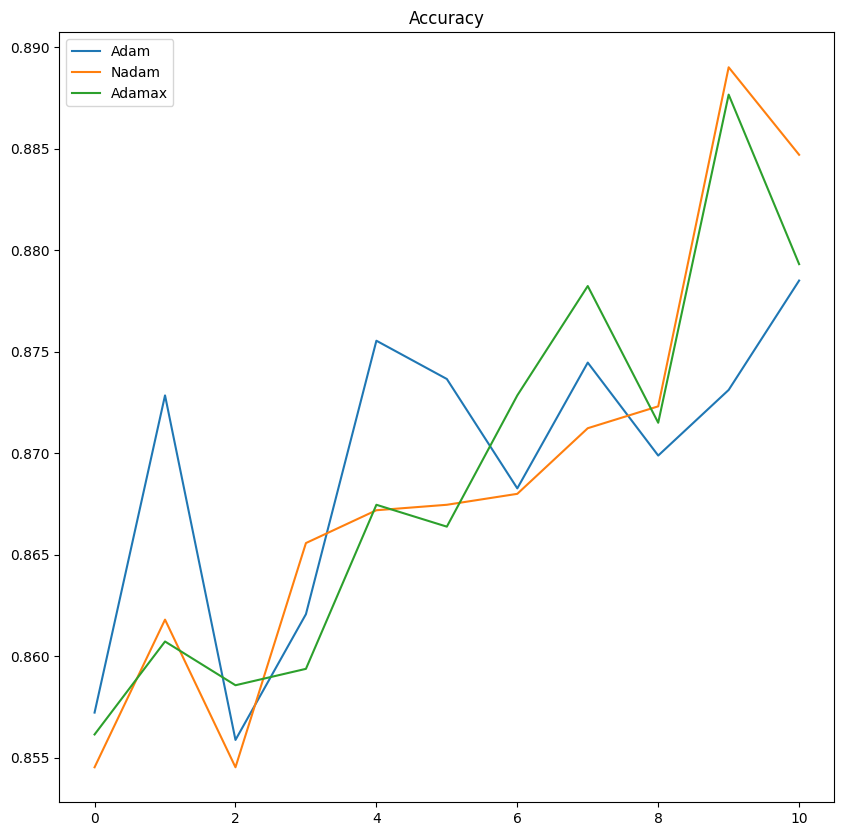

In [ ]:
# Plot the accuracy for the different optimizers on a same graph
plt.figure(figsize=(10, 10))
for result in results_unfrozen:
    plt.plot(result[1]["accuracy"], label=result[0])
plt.title("Accuracy")
plt.legend()
plt.show()

## Conclusion

In [ ]:
# Keep the optimizer with the best accuracy
best_unfrozen_optimizer = None
best_accuracy = 0.0

for result in results_unfrozen:
    if result[1]["accuracy"][-1] > best_accuracy:
        best_accuracy = result[1]["accuracy"][-1]
        best_unfrozen_optimizer = result[0]

print(f"Best frozen optimizer: {best_optimizer}")
print(f"Best unfrozen optimizer: {best_unfrozen_optimizer}")

Best frozen optimizer: Nadam
Best unfrozen optimizer: Nadam


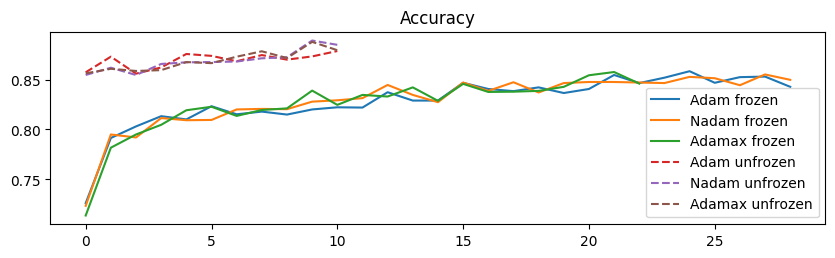

In [ ]:
# Plot the accuracy for the different optimizers on a same graph
# The frozen part in full line and the unfrozen in doted lines
plt.figure(figsize=(10, 2.5))
for result in results_frozen:
    plt.plot(result[1]["accuracy"], label=result[0] + " frozen")
for result in results_unfrozen:
    plt.plot(result[1]["accuracy"], "--", label=result[0] + " unfrozen")
plt.title("Accuracy")
plt.legend()

These tree optimizers are close but the combo Nadam-Nadam give the bests results